[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ILaraPerez/AI4Physics/blob/main/2bproblem.ipynb#scrollTo=Kut4pThrIdlJ)

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Solve using ODE numeric solver

Define conditions for initial value problem:

-Convert sistem of second order to first order by defining angular and radial velocity.

-Set initial conditions: 1 AU, perihelium is 0, 0 radial velocity at p and angular velocity is 2*pi*1UA

-K is equal to G(MS+MT)~4pi² in AU and solar masses.

In [79]:
def ODE(t,y):
    K=4*np.pi**2
##equation defined as y'=f(y,t) where y(t)=[r,phi,v,omega] anf f(y,t)=[v,omega,r*omega-K/r^2,-2*v*omega/r]
    return np.array([y[2],y[3],y[0]*y[3]**2-K/y[0]**2,-2*y[2]*y[3]/y[0]])
y0=[1,0,0,2*np.pi]
t= np.linspace(0, 1, 30)

Solve for values in t and store the values

In [80]:
solution =scipy.integrate.solve_ivp(ODE,[t[0],t[-1]],y0,dense_output=True,t_eval=t);
t_values=np.array(solution.t)
y_values=np.array(solution.y)

Plot

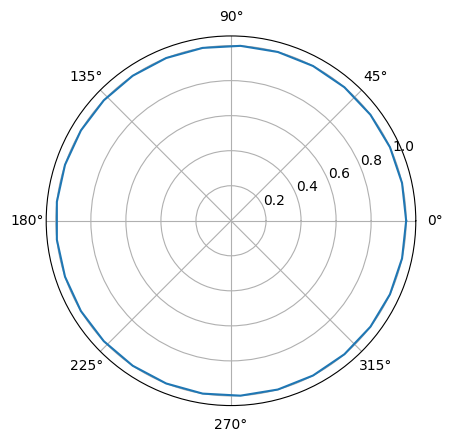

In [81]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(y_values[1,:],y_values[0,:])

## Solve using NN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CUDA support
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = 'cpu'
print(f"device is set to: {device}")

device is set to: cuda


In [127]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.ReLU
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [128]:
torch.manual_seed(999)

y0=np.array([1,0,0,2*np.pi])
t= np.linspace(0, 1, 1000)
K=4*np.pi**2


# define a neural network to train
my_pinn = FCN(1,4,32,3).to(device)
optimiser = torch.optim.Adam(my_pinn.parameters(),lr=1e-3)

# define collocation points over the entire domain
t_collocation = torch.linspace(t[0],t[-1],30).view(-1,1).requires_grad_(True).to(device)# (30, 1)

# define boundary points, for the boundary loss (IC)
t_boundary = t_collocation[0].to(device)  # torch.tensor(0.).view(-1,1).requires_grad_(True)# (1, 1)


def get_pde_loss(t, t0):
    # compute each term of the PINN loss function above

    # compute boundary loss, i.e. IC for u(t) and du/dt
    y0 = my_pinn(t0)# (1, 1)
    #loss1 = (torch.squeeze(u) - 1)**2
    loss1=torch.sum((torch.squeeze(y0)-torch.tensor(np.array([1,0,0,2*np.pi])).to(device))**2)

    # my_nn physics loss
    y = my_pinn(t)# (30, 1)
    drdt = torch.autograd.grad(y[:,0], t, torch.ones_like(y[:,0]), create_graph=True)[0]# (30, 1)
    dphidt = torch.autograd.grad(y[:,1], t, torch.ones_like(y[:,1]), create_graph=True)[0]# (30, 1)
    dvdt = torch.autograd.grad(y[:,2], t, torch.ones_like(y[:,2]), create_graph=True)[0]# (30, 1)
    domegadt = torch.autograd.grad(y[:,3], t, torch.ones_like(y[:,3]), create_graph=True)[0]# (30, 1)
    loss3=torch.mean((torch.squeeze(drdt)-y[:,2])**2+(torch.squeeze(dphidt)-y[:,3])**2+(torch.squeeze(dvdt)-(y[:,0]*y[:,3]**2-K/y[:,0]**2))**2+(torch.squeeze(domegadt)-(-2*y[:,2]*y[:,3]/y[:,0]))**2)
    #loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2) # use pde

    # backpropagate joint loss
    # using the following hyperparameters
    lambda2 = 1e-6
    loss = loss1+lambda2*loss3
    return loss

Training step 0


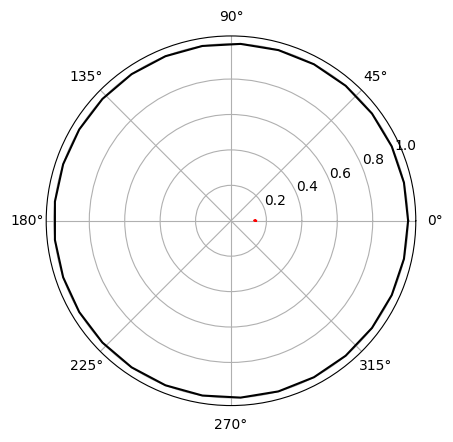

Training step 4000


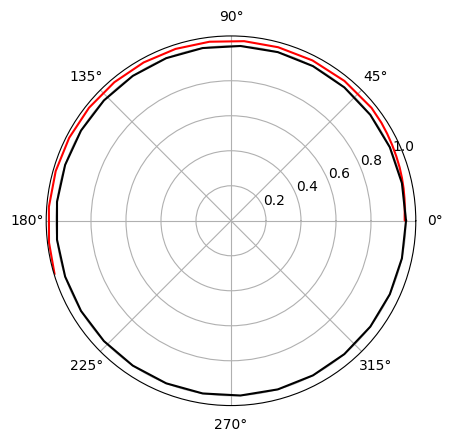

Training step 8000


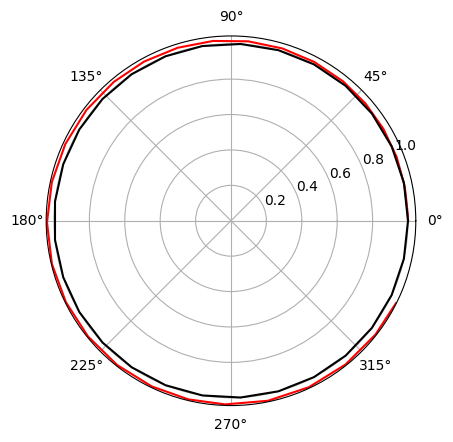

Training step 12000


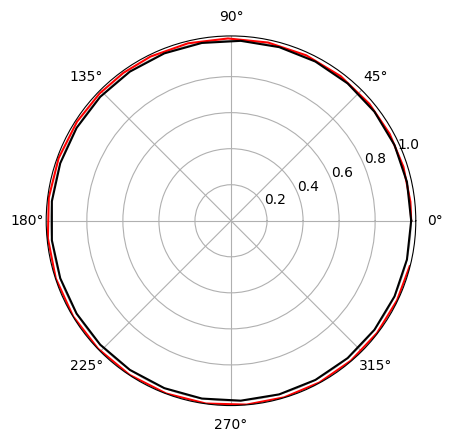

Training step 16000


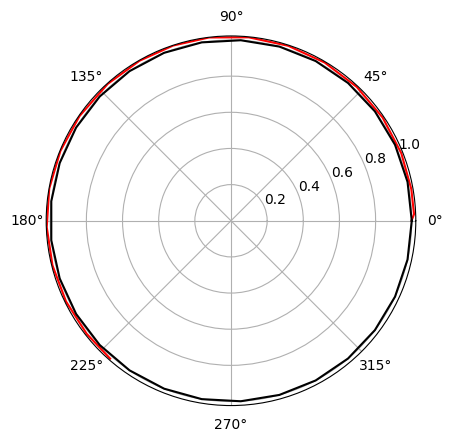

In [129]:
for i in range(16001):
    optimiser.zero_grad()

    loss = get_pde_loss(t_collocation, t_boundary)

    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 4000 == 0:
        print(f"Training step {i}")
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        pred=my_pinn(t_collocation).detach().cpu().numpy()
        ax.plot(pred[:,1],pred[:,0],'r')
        ax.plot(y_values[1,:],y_values[0,:],'k')
        plt.show()